In [1]:
from data import *
import torch.utils.data
train_dataset, test_dataset = get_force_transfer_dataset()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None)

In [2]:
import logging
import time
local_time = time.localtime()
formatter = logging.Formatter(u'%(asctime)s [%(levelname)8s] %(message)s')
file_handler = logging.FileHandler(f'./log/{local_time.tm_year}.{local_time.tm_mon:02}.{local_time.tm_mday:02}.{local_time.tm_hour:02}-{local_time.tm_min:02}-{local_time.tm_sec:02}.log', 'w')
file_handler.setFormatter(formatter)
logger = logging.Logger('main', logging.DEBUG)
logger.addHandler(file_handler)

In [3]:
def seed_everything(seed=42):
    import torch
    import random
    import numpy as np
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
import optuna
from model import *
import torch

def objective(trial:optuna.trial.Trial):
    seed_everything()
    input_size = next(iter(train_dataset))[0].shape[-1]
    output_size = next(iter(train_dataset))[1].shape[-1]

    num_epoch = 100

    model_name = trial.suggest_categorical('model', ['LSTM'])
    if model_name == 'LSTM':
        hidden_size = trial.suggest_categorical('lstm_hidden_size', [8, 16, 32, 64, 128])
        num_layer = trial.suggest_int('lstm_num_layer', 1, 4)
        model = LSTM(input_size, hidden_size, num_layer, output_size)
    
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'SGD'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1, log=True)
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    scheduler_name = trial.suggest_categorical('scheduler',[ 'CosineAnnealingLR'])
    if scheduler_name == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)
    
    criterion = torch.nn.MSELoss()

    
    from tensorboardX import SummaryWriter
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    writer = SummaryWriter()
    
    best_rmse = float('inf')
    for epoch in range(num_epoch):
        model.train()
        criterion.train()
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler_name == 'CosineAnnealingLR':
            scheduler.step()

        model.eval()
        criterion.eval()
        with torch.no_grad():
            mae = []
            mse = []
            num = []
            for X, y in test_loader:
                pred = model(X)
                try:
                    mae.append(mean_absolute_error(y, pred))
                    mse.append(mean_squared_error(y, pred))
                    num.append(len(y))
                except ValueError:
                    print(f'{epoch=}')
                    print(f'{trial.params=}')
                    print(f'{y=}')
                    print(f'{pred=}')
                    return best_rmse
            mae = np.array(mae)
            mse = np.array(mse)
            num = np.array(num)
            mae = (mae * num).sum() / sum(num)
            mse = (mse * num).sum() / sum(num)
            
            rmse = mse ** 0.5
            writer.add_scalar('metric/MAE', mae, epoch)
            writer.add_scalar('metric/RMSE', rmse, epoch)
            best_rmse = min(rmse, best_rmse)
            
            trial.report(rmse, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_rmse

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-05-25 19:32:32,142] A new study created in memory with name: no-name-913c78ca-6208-4fca-8235-cba46ee96f37
[I 2023-05-25 19:33:53,899] Trial 0 finished with value: 259.27490478874626 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 8, 'lstm_num_layer': 3, 'optimizer': 'SGD', 'learning_rate': 0.0005756325677434214, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 259.27490478874626.
[I 2023-05-25 19:34:28,411] Trial 1 finished with value: 213.60227020172593 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 16, 'lstm_num_layer': 1, 'optimizer': 'SGD', 'learning_rate': 0.0004459811220878294, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 213.60227020172593.
[I 2023-05-25 19:43:26,000] Trial 2 finished with value: 381.7272553077345 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 4, 'optimizer': 'Adagrad', 'learning_rate': 0.00018382443345535616, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 213.6022

epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 2, 'optimizer': 'Adam', 'learning_rate': 0.930036314261639, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:06:48,696] Trial 21 finished with value: 163.903626791104 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.2864961772456255, 'scheduler': 'CosineAnnealingLR'}. Best is trial 13 with value: 157.31229893516397.
[I 2023-05-25 20:08:17,506] Trial 22 finished with value: 164.5118540843471 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.3382589987743395, 'scheduler': 'CosineAnnealingLR'}. Best is trial 13 with value: 157.31229893516397.
[I 2023-05-25 20:11:07,495] Trial 23 finished with value: 152.36736185356068 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.29982400681704074, 'scheduler': 'CosineAnnealingLR'}. Best is trial 23 with value: 152.36736185356068.
[I 2023-05-25 20:14:11,026] Trial 24 finished with value: 200.36888687559926 and parameters: {'model': 'LST

epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.511427952726841, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:19:34,746] Trial 32 finished with value: inf and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.7418080117147272, 'scheduler': 'CosineAnnealingLR'}. Best is trial 30 with value: 151.9981224186465.


epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.7418080117147272, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:22:05,819] Trial 33 finished with value: 151.86704630771854 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.28320246484544553, 'scheduler': 'CosineAnnealingLR'}. Best is trial 33 with value: 151.86704630771854.
[I 2023-05-25 20:24:45,570] Trial 34 finished with value: 183.80096203404105 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.48264767231264566, 'scheduler': 'CosineAnnealingLR'}. Best is trial 33 with value: 151.86704630771854.
[I 2023-05-25 20:24:51,440] Trial 35 pruned. 
[I 2023-05-25 20:24:51,855] Trial 36 pruned. 
[I 2023-05-25 20:25:22,502] Trial 37 pruned. 
[I 2023-05-25 20:25:29,622] Trial 38 pruned. 
[I 2023-05-25 20:27:54,297] Trial 39 finished with value: 190.46027152296503 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'SGD', 'learning_rate': 0.012188551701528603, 

epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.972927189715734, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:29:34,144] Trial 49 pruned. 
[I 2023-05-25 20:29:34,468] Trial 50 pruned. 
[I 2023-05-25 20:29:35,269] Trial 51 pruned. 
[I 2023-05-25 20:29:36,147] Trial 52 pruned. 
[I 2023-05-25 20:29:37,018] Trial 53 pruned. 
[I 2023-05-25 20:30:57,106] Trial 54 finished with value: 177.47193121527607 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.44996286496134436, 'scheduler': 'CosineAnnealingLR'}. Best is trial 33 with value: 151.86704630771854.
[I 2023-05-25 20:30:59,027] Trial 55 pruned. 
[I 2023-05-25 20:30:59,845] Trial 56 pruned. 
[I 2023-05-25 20:31:00,237] Trial 57 pruned. 
[I 2023-05-25 20:31:02,140] Trial 58 pruned. 
[I 2023-05-25 20:31:03,423] Trial 59 finished with value: inf and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.9865445893837248, 'scheduler': 'CosineAnnealingLR'}. Best is trial 33 with value: 151.86704630771854.


epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.9865445893837248, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:31:03,947] Trial 60 pruned. 
[I 2023-05-25 20:33:37,415] Trial 61 finished with value: 158.0705354874732 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.41003683104446914, 'scheduler': 'CosineAnnealingLR'}. Best is trial 33 with value: 151.86704630771854.
[I 2023-05-25 20:36:03,492] Trial 62 finished with value: 146.81461074315106 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.3502354030064202, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.
[I 2023-05-25 20:38:35,113] Trial 63 finished with value: 148.5014881302651 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.6699139690068732, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.
[I 2023-05-25 20:41:10,850] Trial 64 finished with value: 

epoch=1
trial.params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.7403532899785782, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:46:18,188] Trial 69 pruned. 
[I 2023-05-25 20:46:22,061] Trial 70 pruned. 
[I 2023-05-25 20:46:23,367] Trial 71 finished with value: inf and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.9996046053745469, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.


epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.9996046053745469, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 20:46:29,617] Trial 72 pruned. 
[I 2023-05-25 20:48:59,427] Trial 73 finished with value: 184.306538104759 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.7560867714162185, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.
[I 2023-05-25 20:51:35,233] Trial 74 finished with value: 150.72499097921263 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.4992840691142553, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.
[I 2023-05-25 20:54:02,972] Trial 75 finished with value: 152.82206828924535 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.48723883693821124, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.
[I 2023-05-25 20:54:04,688] Trial 76 pruned. 
[I 2023-05-2

epoch=0
trial.params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.4887642485827906, 'scheduler': 'CosineAnnealingLR'}
y=tensor([[232., 941., 758.,   0.,  35.,   0.],
        [251., 974., 792.,   0.,  37.,   3.],
        [246., 984., 824.,   0.,  34.,   0.],
        ...,
        [ 83.,   0.,  27.,   0., 225.,   0.],
        [ 59.,   0.,   0.,   0., 201.,   0.],
        [ 32.,   0.,   0.,   0., 152.,   0.]])
pred=tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])


[I 2023-05-25 21:02:11,302] Trial 82 finished with value: 150.28278261167395 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.27074823012366483, 'scheduler': 'CosineAnnealingLR'}. Best is trial 62 with value: 146.81461074315106.
[I 2023-05-25 21:04:44,648] Trial 83 finished with value: 145.17862743351446 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.2726619637519615, 'scheduler': 'CosineAnnealingLR'}. Best is trial 83 with value: 145.17862743351446.
[I 2023-05-25 21:04:46,507] Trial 84 pruned. 
[I 2023-05-25 21:07:13,512] Trial 85 finished with value: 144.29852166127995 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.2669145710785039, 'scheduler': 'CosineAnnealingLR'}. Best is trial 85 with value: 144.29852166127995.
[I 2023-05-25 21:07:15,146] Trial 86 pruned. 
[I 2023-05

In [5]:
study.best_params

{'model': 'LSTM',
 'lstm_hidden_size': 128,
 'lstm_num_layer': 1,
 'optimizer': 'Adam',
 'learning_rate': 0.3887547452101927,
 'scheduler': 'CosineAnnealingLR'}

In [7]:
study.best_trial

FrozenTrial(number=93, state=TrialState.COMPLETE, values=[143.48159413136727], datetime_start=datetime.datetime(2023, 5, 25, 21, 10, 10, 604233), datetime_complete=datetime.datetime(2023, 5, 25, 21, 12, 50, 396209), params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.3887547452101927, 'scheduler': 'CosineAnnealingLR'}, user_attrs={}, system_attrs={}, intermediate_values={0: 230.76802913232518, 1: 187.77649677110958, 2: 179.9816040500257, 3: 160.90173789784058, 4: 160.1743096107567, 5: 143.48159413136727, 6: 159.36617253402648, 7: 154.0503633577367, 8: 150.84665562715048, 9: 162.84797450897494, 10: 176.23500119898682, 11: 189.59188993180993, 12: 168.28834172615763, 13: 175.54366259642913, 14: 173.407281789584, 15: 165.20271105986663, 16: 165.9597996548858, 17: 177.95202569027387, 18: 178.4075867891128, 19: 194.63478278968242, 20: 196.44999332202264, 21: 182.6986942359706, 22: 183.55668190526308, 23: 177.83706751755304, 24: 178.2

In [10]:
study.best_trials

[FrozenTrial(number=93, state=TrialState.COMPLETE, values=[143.48159413136727], datetime_start=datetime.datetime(2023, 5, 25, 21, 10, 10, 604233), datetime_complete=datetime.datetime(2023, 5, 25, 21, 12, 50, 396209), params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 1, 'optimizer': 'Adam', 'learning_rate': 0.3887547452101927, 'scheduler': 'CosineAnnealingLR'}, user_attrs={}, system_attrs={}, intermediate_values={0: 230.76802913232518, 1: 187.77649677110958, 2: 179.9816040500257, 3: 160.90173789784058, 4: 160.1743096107567, 5: 143.48159413136727, 6: 159.36617253402648, 7: 154.0503633577367, 8: 150.84665562715048, 9: 162.84797450897494, 10: 176.23500119898682, 11: 189.59188993180993, 12: 168.28834172615763, 13: 175.54366259642913, 14: 173.407281789584, 15: 165.20271105986663, 16: 165.9597996548858, 17: 177.95202569027387, 18: 178.4075867891128, 19: 194.63478278968242, 20: 196.44999332202264, 21: 182.6986942359706, 22: 183.55668190526308, 23: 177.83706751755304, 24: 178.

In [12]:
import pickle
pickle.dump(study, open('./study1.pkl', 'wb'))

In [13]:
study.best_value

143.48159413136727

In [54]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler,state
0,0,259.274905,2023-05-25 19:32:32.144399,2023-05-25 19:33:53.898728,0 days 00:01:21.754329,0.000576,8,3,LSTM,SGD,CosineAnnealingLR,COMPLETE
1,1,213.602270,2023-05-25 19:33:53.900725,2023-05-25 19:34:28.410725,0 days 00:00:34.510000,0.000446,16,1,LSTM,SGD,CosineAnnealingLR,COMPLETE
2,2,381.727255,2023-05-25 19:34:28.412725,2023-05-25 19:43:26.000054,0 days 00:08:57.587329,0.000184,128,4,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
3,3,371.157395,2023-05-25 19:43:26.002055,2023-05-25 19:44:54.215741,0 days 00:01:28.213686,0.021584,16,3,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
4,4,380.207207,2023-05-25 19:44:54.216740,2023-05-25 19:47:16.165594,0 days 00:02:21.948854,0.001147,64,2,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,360.634726,2023-05-25 21:15:25.700727,2023-05-25 21:15:26.097392,0 days 00:00:00.396665,0.268729,16,1,LSTM,Adam,CosineAnnealingLR,PRUNED
96,96,262.593304,2023-05-25 21:15:26.099390,2023-05-25 21:15:27.902141,0 days 00:00:01.802751,0.185020,128,1,LSTM,Adam,CosineAnnealingLR,PRUNED
97,97,207.403493,2023-05-25 21:15:27.903142,2023-05-25 21:15:31.000301,0 days 00:00:03.097159,0.824156,128,1,LSTM,Adam,CosineAnnealingLR,PRUNED
98,98,311.844212,2023-05-25 21:15:31.003300,2023-05-25 21:15:31.496723,0 days 00:00:00.493423,0.354449,32,1,LSTM,Adam,CosineAnnealingLR,PRUNED


In [55]:
df[df['params_optimizer'] == 'Adagrad']

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler,state
2,2,381.727255,2023-05-25 19:34:28.412725,2023-05-25 19:43:26.000054,0 days 00:08:57.587329,0.000184,128,4,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
3,3,371.157395,2023-05-25 19:43:26.002055,2023-05-25 19:44:54.215741,0 days 00:01:28.213686,0.021584,16,3,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
4,4,380.207207,2023-05-25 19:44:54.216740,2023-05-25 19:47:16.165594,0 days 00:02:21.948854,0.001147,64,2,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
25,25,359.566008,2023-05-25 20:14:11.027488,2023-05-25 20:14:15.097486,0 days 00:00:04.069998,0.058986,128,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
29,29,375.886888,2023-05-25 20:17:01.946711,2023-05-25 20:17:02.769027,0 days 00:00:00.822316,0.243884,8,3,LSTM,Adagrad,CosineAnnealingLR,PRUNED
35,35,292.944801,2023-05-25 20:24:45.571902,2023-05-25 20:24:51.440253,0 days 00:00:05.868351,0.890723,128,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
38,38,311.001816,2023-05-25 20:25:22.503852,2023-05-25 20:25:29.622111,0 days 00:00:07.118259,0.530133,128,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
57,57,368.190398,2023-05-25 20:30:59.847371,2023-05-25 20:31:00.237093,0 days 00:00:00.389722,0.374310,16,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
69,69,318.110586,2023-05-25 20:46:16.044145,2023-05-25 20:46:18.187565,0 days 00:00:02.143420,0.238014,128,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
87,87,375.789447,2023-05-25 21:07:15.147650,2023-05-25 21:07:15.567280,0 days 00:00:00.419630,0.328640,8,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED


In [35]:
df = df[df['state']=='COMPLETE'].drop(['number', 'datetime_start', 'datetime_complete', 'state'], axis=1)
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,259.274905,0 days 00:01:21.754329,0.000576,8,3,LSTM,SGD,CosineAnnealingLR
1,213.602270,0 days 00:00:34.510000,0.000446,16,1,LSTM,SGD,CosineAnnealingLR
2,381.727255,0 days 00:08:57.587329,0.000184,128,4,LSTM,Adagrad,CosineAnnealingLR
3,371.157395,0 days 00:01:28.213686,0.021584,16,3,LSTM,Adagrad,CosineAnnealingLR
4,380.207207,0 days 00:02:21.948854,0.001147,64,2,LSTM,Adagrad,CosineAnnealingLR
5,233.637659,0 days 00:00:28.536879,0.027361,8,1,LSTM,SGD,CosineAnnealingLR
6,249.569031,0 days 00:02:37.710037,0.000159,32,4,LSTM,SGD,CosineAnnealingLR
8,192.996321,0 days 00:01:12.662822,0.002340,64,1,LSTM,SGD,CosineAnnealingLR
10,184.019962,0 days 00:01:21.594017,0.360191,64,1,LSTM,Adam,CosineAnnealingLR
11,170.780523,0 days 00:01:38.830606,0.563752,64,1,LSTM,Adam,CosineAnnealingLR


In [42]:
df['duration'] = df['duration'] / np.timedelta64(1, 's')
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,259.274905,81.754329,0.000576,8,3,LSTM,SGD,CosineAnnealingLR
1,213.602270,34.510000,0.000446,16,1,LSTM,SGD,CosineAnnealingLR
2,381.727255,537.587329,0.000184,128,4,LSTM,Adagrad,CosineAnnealingLR
3,371.157395,88.213686,0.021584,16,3,LSTM,Adagrad,CosineAnnealingLR
4,380.207207,141.948854,0.001147,64,2,LSTM,Adagrad,CosineAnnealingLR
5,233.637659,28.536879,0.027361,8,1,LSTM,SGD,CosineAnnealingLR
6,249.569031,157.710037,0.000159,32,4,LSTM,SGD,CosineAnnealingLR
8,192.996321,72.662822,0.002340,64,1,LSTM,SGD,CosineAnnealingLR
10,184.019962,81.594017,0.360191,64,1,LSTM,Adam,CosineAnnealingLR
11,170.780523,98.830606,0.563752,64,1,LSTM,Adam,CosineAnnealingLR


In [45]:
df = df[df['value']!=np.inf]
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,259.274905,81.754329,0.000576,8,3,LSTM,SGD,CosineAnnealingLR
1,213.602270,34.510000,0.000446,16,1,LSTM,SGD,CosineAnnealingLR
2,381.727255,537.587329,0.000184,128,4,LSTM,Adagrad,CosineAnnealingLR
3,371.157395,88.213686,0.021584,16,3,LSTM,Adagrad,CosineAnnealingLR
4,380.207207,141.948854,0.001147,64,2,LSTM,Adagrad,CosineAnnealingLR
5,233.637659,28.536879,0.027361,8,1,LSTM,SGD,CosineAnnealingLR
6,249.569031,157.710037,0.000159,32,4,LSTM,SGD,CosineAnnealingLR
8,192.996321,72.662822,0.002340,64,1,LSTM,SGD,CosineAnnealingLR
10,184.019962,81.594017,0.360191,64,1,LSTM,Adam,CosineAnnealingLR
11,170.780523,98.830606,0.563752,64,1,LSTM,Adam,CosineAnnealingLR


In [52]:
df.sort_values('value')

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
93,143.481594,159.791976,0.388755,128,1,LSTM,Adam,CosineAnnealingLR
85,144.298522,147.003632,0.266915,128,1,LSTM,Adam,CosineAnnealingLR
83,145.178627,153.344173,0.272662,128,1,LSTM,Adam,CosineAnnealingLR
62,146.814611,146.074646,0.350235,128,1,LSTM,Adam,CosineAnnealingLR
91,147.625572,159.714522,0.271974,128,1,LSTM,Adam,CosineAnnealingLR
63,148.501488,151.620144,0.669914,128,1,LSTM,Adam,CosineAnnealingLR
64,149.830229,155.735360,0.685084,128,1,LSTM,Adam,CosineAnnealingLR
82,150.282783,160.549392,0.270748,128,1,LSTM,Adam,CosineAnnealingLR
74,150.724991,155.804717,0.499284,128,1,LSTM,Adam,CosineAnnealingLR
33,151.867046,151.070592,0.283202,128,1,LSTM,Adam,CosineAnnealingLR


<Axes: >

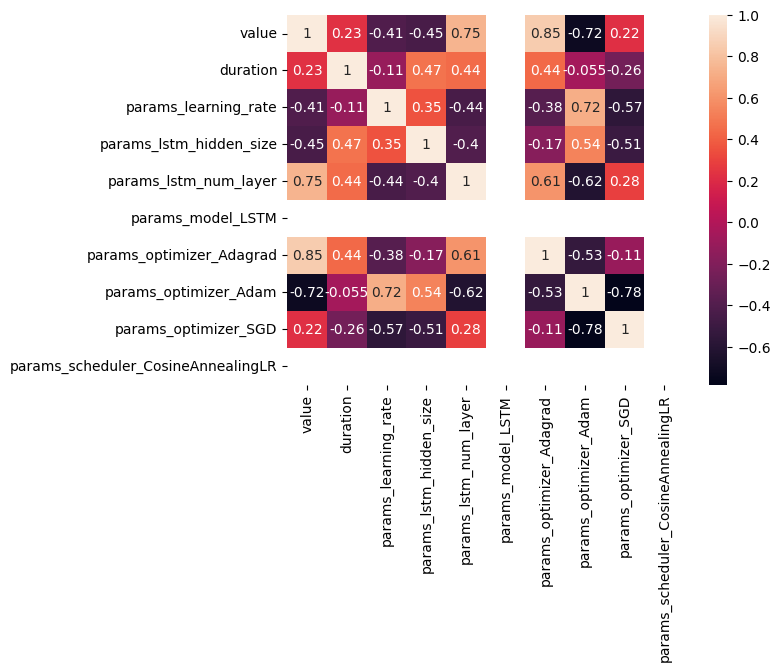

In [50]:
import seaborn as sns
sns.heatmap(pd.get_dummies(df, ['params_model', 'params_optimizer', 'params_scheduler']).corr(), annot=True)